In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("neural-craft-2026/train_complaints.csv")
test_df = pd.read_csv("neural-craft-2026/test_complaints.csv")

# Data Analysis

In [3]:
train_df.head()

,complaint_id,complaint_text,primary_category,secondary_category,severity
0,1634299,Back into XXXX of 2010 during this mortgage cr...,Mortgage,"Loan modification,collection,foreclosure",2
1,5505088,I checked my credit report and I am upset on w...,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,1
2,10979675,I am writing to dispute the accuracy of the in...,Credit reporting or other personal consumer re...,Problem with a company's investigation into an...,1
3,7520351,A transaction from XXXX XXXX XXXX submitted a ...,Checking or savings account,Managing an account,1
4,5847870,I was recently alerted to an account in collec...,Debt collection,Attempts to collect debt not owed,5


In [4]:
test_df.head()

,complaint_id,complaint_text
0,7799230,IN ACCORDANCE TO THE FAIR CREDIT REPORTING ACT...
1,15754196,I understand the importance of removing any in...
2,10989146,I have a goal of getting a house as soon as po...
3,3617850,Ive filed a dispute regarding the results on m...
4,5253879,I have sent letters to XXXX and XXXX about the...


In [5]:
train_df.shape
train_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   complaint_id        2999 non-null   int64
 1   complaint_text      2999 non-null   str  
 2   primary_category    2999 non-null   str  
 3   secondary_category  2999 non-null   str  
 4   severity            2999 non-null   int64
dtypes: int64(2), str(3)
memory usage: 3.5 MB


In [6]:
test_df.shape
test_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   complaint_id    499 non-null    int64
 1   complaint_text  499 non-null    str  
dtypes: int64(1), str(1)
memory usage: 498.0 KB


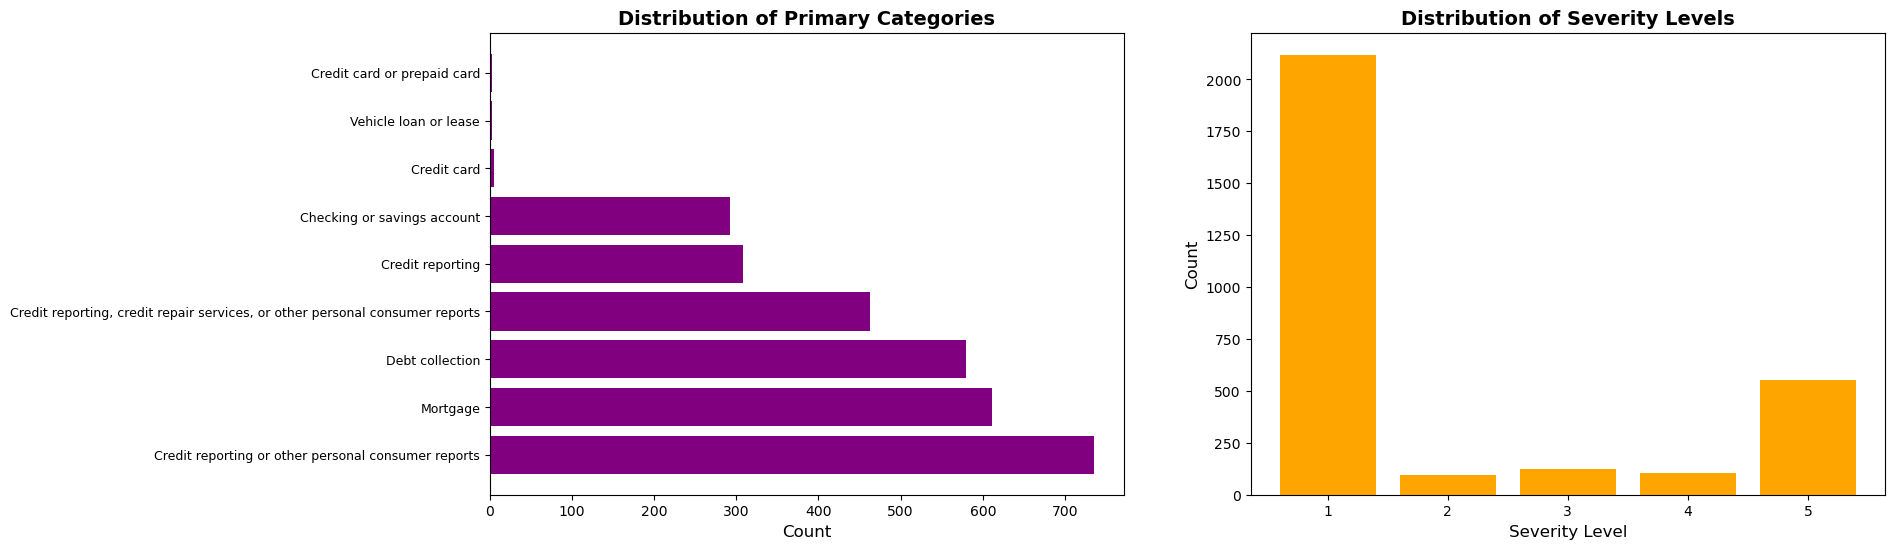


Number of unique primary categories: 9
Number of unique secondary categories: 10

Severity distribution:
severity
1    2119
2      94
3     126
4     106
5     554
Name: count, dtype: int64


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Primary Category Distribution
primary_counts = train_df['primary_category'].value_counts()
axes[0].barh(range(len(primary_counts)), primary_counts.values, color='purple')
axes[0].set_yticks(range(len(primary_counts)))
axes[0].set_yticklabels(primary_counts.index, fontsize=9)
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_title('Distribution of Primary Categories', fontsize=14, fontweight='bold')

# Severity Distribution
severity_counts = train_df['severity'].value_counts().sort_index()
axes[1].bar(severity_counts.index, severity_counts.values, color='orange')
axes[1].set_xlabel('Severity Level', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution of Severity Levels', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, 6))

plt.show()

print(f"\nNumber of unique primary categories: {train_df['primary_category'].nunique()}")
print(f"Number of unique secondary categories: {train_df['secondary_category'].nunique()}")
print(f"\nSeverity distribution:\n{severity_counts}")

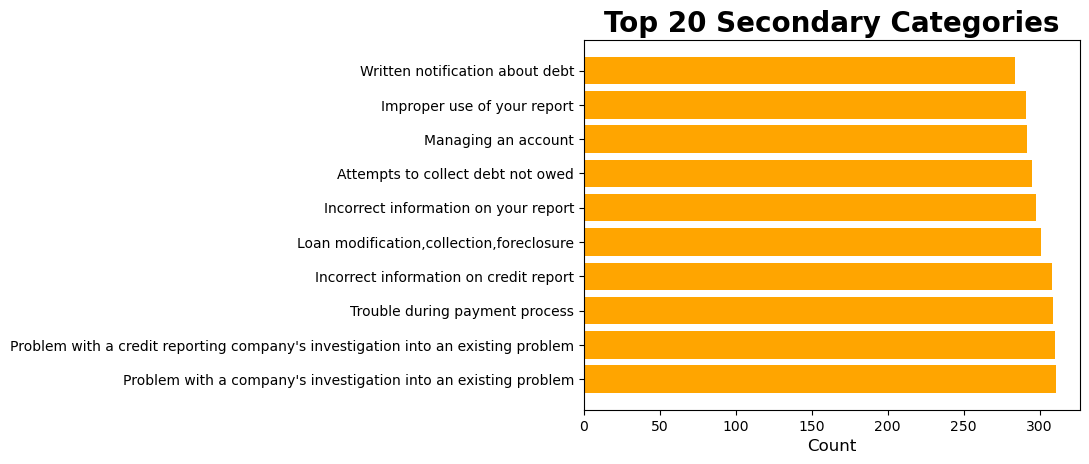

In [8]:
fig, ax = plt.subplots()

secondary_counts = train_df['secondary_category'].value_counts().head(20)
ax.barh(range(len(secondary_counts)), secondary_counts.values, color='orange')
ax.set_yticks(range(len(secondary_counts)))
ax.set_yticklabels(secondary_counts.index, fontsize=10)
ax.set_xlabel('Count', fontsize=12)
ax.set_title('Top 20 Secondary Categories',fontsize=20, fontweight='bold')


plt.show()

# Cleaning of data 

In [9]:
def clean_complaint_text(text):
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', ' ', text)
    text = re.sub(r'xxxx', ' ', text)
    text = re.sub(r'\b\d{5,}\b', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['cleaned_text'] = train_df['complaint_text'].apply(clean_complaint_text)
test_df['cleaned_text'] = test_df['complaint_text'].apply(clean_complaint_text)

# Test validation split/

In [10]:
# Split before creating features to avoid indexing issues
train_data, val_data = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42,
    stratify=train_df['primary_category']
)

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")


Train samples: 2399
Validation samples: 600


# Vectorization

In [11]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.85,
    sublinear_tf=True
)

# Fit on training data, transform both train and validation
X_train_tfidf = vectorizer.fit_transform(train_data['cleaned_text'])
X_val_tfidf = vectorizer.transform(val_data['cleaned_text'])
X_test_tfidf = vectorizer.transform(test_df['cleaned_text'])

print(f"{X_train_tfidf.shape}")

(2399, 5000)


# Feature engineering 

In [12]:
# Additional features
def extract_features(df):
    features = pd.DataFrame()
    
    text_lower = df['complaint_text'].str.lower()
    
    features['char_count'] = df['complaint_text'].str.len()
    features['word_count'] = df['complaint_text'].str.split().str.len()
    features['fraud_scam'] = text_lower.str.contains('fraud|scam|unauthorized|stolen', na=False).astype(int)
    features['legal'] = text_lower.str.contains('lawsuit|attorney|lawyer|legal', na=False).astype(int)
    features['credit_card'] = text_lower.str.contains('credit card', na=False).astype(int)
    features['mortgage'] = text_lower.str.contains('mortgage', na=False).astype(int)
    features['checking_savings'] = text_lower.str.contains('checking|savings', na=False).astype(int)
    features['debt_collection'] = text_lower.str.contains('debt collect|collection', na=False).astype(int)
    features['credit_report'] = text_lower.str.contains('credit report|credit bureau', na=False).astype(int)
    features['dispute'] = text_lower.str.contains('dispute|incorrect|error|inaccurate', na=False).astype(int)
    features['payment'] = text_lower.str.contains('payment|pay', na=False).astype(int)
    features['exclamation'] = df['complaint_text'].str.count('!').fillna(0)
    features['question'] = df['complaint_text'].str.count('\?').fillna(0)
    
    return features.values

train_features = extract_features(train_data)
val_features = extract_features(val_data)
test_features = extract_features(test_df)

print(f"features extracted:{train_features.shape[1]} features")

features extracted:13 features


In [13]:
# Combine features
import scipy.sparse as sp
X_train = sp.hstack([X_train_tfidf, train_features])
X_val = sp.hstack([X_val_tfidf, val_features])
X_test = sp.hstack([X_test_tfidf, test_features])

print(f"Total combined features:{X_train.shape}")

Total combined features:(2399, 5013)


In [14]:
# Encode primary category
primary_encoder = LabelEncoder()
y_train_primary = primary_encoder.fit_transform(train_data['primary_category'])
y_val_primary = primary_encoder.transform(val_data['primary_category'])

# Encode secondary category
secondary_encoder = LabelEncoder()
y_train_secondary = secondary_encoder.fit_transform(train_data['secondary_category'])
y_val_secondary = secondary_encoder.transform(val_data['secondary_category'])

# Severity is already numeric
y_train_severity = train_data['severity'].values
y_val_severity = val_data['severity'].values

print(f" Primary categories: {len(primary_encoder.classes_)}")
print(f" Secondary categories: {len(secondary_encoder.classes_)}")
print(f" Severity range: {y_train_severity.min()} to {y_train_severity.max()}")


 Primary categories: 9
 Secondary categories: 10
 Severity range: 1 to 5


In [15]:
primary_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
primary_model.fit(X_train, y_train_primary)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",30
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [16]:
# Model 2: Secondary Category Classifier
secondary_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
secondary_model.fit(X_train, y_train_secondary)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",30
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [17]:

# Model 3: Severity Regressor
severity_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    min_samples_split=5,
    random_state=42
)
severity_model.fit(X_train, y_train_severity)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",200
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",7
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

In [18]:
# Predict on validation set
val_pred_primary = primary_model.predict(X_val)
val_pred_secondary = secondary_model.predict(X_val)
val_pred_severity = severity_model.predict(X_val)

# Calculate accuracy
primary_acc = accuracy_score(y_val_primary, val_pred_primary)
secondary_acc = accuracy_score(y_val_secondary, val_pred_secondary)
severity_r2 = r2_score(y_val_severity, val_pred_severity)

# Weighted score
weighted_score = 0.3 * primary_acc + 0.4 * secondary_acc + 0.3 * severity_r2

print(f"Validation Results:")
print(f"Primary Accuracy: {primary_acc:.4f} (weight: 0.3)")
print(f"Secondary Accuracy: {secondary_acc:.4f} (weight: 0.4)")
print(f"Severity R²: {severity_r2:.4f} (weight: 0.3)")
print(f"WEIGHTED SCORE: {weighted_score:.4f}")

Validation Results:
Primary Accuracy: 0.7267 (weight: 0.3)
Secondary Accuracy: 0.6033 (weight: 0.4)
Severity R²: 0.9401 (weight: 0.3)
WEIGHTED SCORE: 0.7413


In [19]:
# Predict all three outputs
test_pred_primary = primary_model.predict(X_test)
test_pred_secondary = secondary_model.predict(X_test)
test_pred_severity = severity_model.predict(X_test)

# Decode categories
test_primary_decoded = primary_encoder.inverse_transform(test_pred_primary)
test_secondary_decoded = secondary_encoder.inverse_transform(test_pred_secondary)

# Clip and round severity to valid range [1, 5]
test_severity_final = np.clip(np.round(test_pred_severity), 1, 5).astype(int)

print(f"Generated {len(test_df)} predictions")

Generated 499 predictions


In [20]:
submission = pd.DataFrame({
    'complaint_id': test_df['complaint_id'],
    'primary_category': test_primary_decoded,
    'secondary_category': test_secondary_decoded,
    'severity': test_severity_final
})
submission.to_csv('submission.csv', index=False)

print(f"Submission saved")

Submission saved
